open packages

In [1]:
library(dlnm)
library(splines)
library(tidyverse)
library(nlme)
library(lme4)
library(foreach)
library(doParallel)
library(doSNOW)

This is dlnm 2.2.6. For details: help(dlnm) and vignette('dlnmOverview').
Important changes: see file.show(system.file('Changesince220',package='dlnm'))
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand


Attaching package: 'lme4'

The following object is masked from 'package:nlme':

    lmList


Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loading required package: iterators
Loading required package: parallel
Loading required package: snow

Attaching package: 'snow'

The follow

data prep

In [2]:
## open files ##
data_path = "F:/Users/Jason/Desktop/Health_data/DLNMs/data_files"

dane_admits = read_csv(paste(data_path,"admissions_daily_countywide.csv",sep="/"))
zip_temps = read_csv(paste(data_path,"temperatures_ZCTA_daily.csv",sep="/"))
zip_admits = read_csv(paste(data_path,"admissions_daily_ZCTA.csv",sep="/"))
zip_census = read_csv(paste(data_path,"census_ZCTA.csv",sep="/"))
AQ = read_csv(paste(data_path,"AQ_data.csv",sep="/"))

## prep zip_df ##
zip_temps = merge(zip_temps, AQ, by="DATE", all.x=T)
zip_df = merge(zip_admits, zip_temps, by=c("DATE","ZIP"), all.x=T)
zip_df = merge(zip_df, zip_census, by="ZIP", all.x=T)
zip_df$DATE = as.Date(zip_df$DATE, format="%m-%d-%y")
zip_df = zip_df[order(zip_df$DATE),]
zip_df$DOW = weekdays(zip_df$DATE)
zip_df$DOY = as.integer(strftime(zip_df$DATE, format = "%j"))
zip_df$WEEK = (zip_df$DOY-1)%/%7 + 1
zip_df$MONTH = as.integer(strftime(zip_df$DATE, format = "%m")) 
zip_df$YEAR = as.integer(strftime(zip_df$DATE, format = "%y"))
zip_df$WEEKEND = ifelse(zip_df$DOW == "Saturday" | zip_df$DOW == "Sunday", 1, 0)

## population weighted ATs for countywide analysis ##
w1 = zip_df
w1$wATMAX = w1$ATMAX*w1$POP/sum(zip_census$POP)
w1$wATMIN = w1$ATMIN*w1$POP/sum(zip_census$POP)
dane_temps <- aggregate(c(w1["wATMAX"],w1["wATMIN"]), by=w1[c("DATE")], FUN=sum, na.rm=T)
colnames(dane_temps) = c("DATE","ATMAX","ATMIN")

## prep dane_df
dane_admits$DATE = as.Date(dane_admits$DATE, format="%m-%d-%y")
AQ$DATE = as.Date(AQ$DATE, format="%m-%d-%y")
dane_temps = merge(dane_temps, AQ, by="DATE", all.x=T)
dane_df = merge(dane_admits, dane_temps, by="DATE", all.x=T)
dane_df = dane_df[order(dane_df$DATE),]
dane_df$DOW = weekdays(dane_df$DATE)
dane_df$DOY = as.integer(strftime(dane_df$DATE, format = "%j"))
dane_df$WEEK = (dane_df$DOY-1)%/%7 + 1
dane_df$MONTH = as.integer(strftime(dane_df$DATE, format = "%m")) 
dane_df$YEAR = as.integer(strftime(dane_df$DATE, format = "%y"))
dane_df$WEEKEND = ifelse(dane_df$DOW == "Saturday" | dane_df$DOW == "Sunday", 1, 0)
dane_df$obsno = seq(1,nrow(dane_df),1)
dane_df$prev_1_ATMAX = c(NA, head(dane_df['ATMAX'], dim(dane_df)[1] - 1)[[1]])
dane_df$prev_2_ATMAX = rollmean(dane_df$ATMAX,2,fill=NA,align='right')
dane_df$prev_3_ATMAX = rollmean(dane_df$ATMAX,3,fill=NA,align='right')
dane_df$prev_1_ATMIN = c(NA, head(dane_df['ATMIN'], dim(dane_df)[1] - 1)[[1]])
dane_df$prev_2_ATMIN = rollmean(dane_df$ATMIN,2,fill=NA,align='right')
dane_df$prev_3_ATMIN = rollmean(dane_df$ATMIN,3,fill=NA,align='right')

dane_df = subset(dane_df, MONTH!=4)
zip_df = subset(zip_df, MONTH!=4)
obsno = data.frame(dane_df[,c("DATE","obsno")])
zip_df = merge(zip_df,obsno,by="DATE")

Parsed with column specification:
cols(
  DATE = col_character(),
  ADMITS = col_integer()
)
Parsed with column specification:
cols(
  DATE = col_character(),
  ZIP = col_integer(),
  ATMAX = col_double(),
  ATMIN = col_double()
)
Parsed with column specification:
cols(
  ZIP = col_integer(),
  DATE = col_character(),
  ADMITS = col_integer(),
  EXPECTED = col_integer()
)
Parsed with column specification:
cols(
  .default = col_double(),
  ID = col_integer(),
  ZIP = col_integer(),
  AWATER10 = col_integer(),
  ALAND10 = col_integer(),
  GEOID10 = col_integer(),
  POP = col_integer(),
  PERCAPINC = col_integer(),
  MANY_STUDE = col_integer(),
  MEDIAN_INC = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  DATE = col_character(),
  O3 = col_double(),
  PM25 = col_double()
)


ERROR: Error in eval(expr, envir, enclos): could not find function "rollmean"


overdispersion testing function for poisson models

In [4]:
overdisp_fun <- function(model) {
	## number of variance parameters in 
	##   an n-by-n variance-covariance matrix
	vpars <- function(m) {
		nrow(m)*(nrow(m)+1)/2
		}
	model.df <- sum(sapply(VarCorr(model),vpars))+length(fixef(model))
	rdf <- nrow(model.frame(model))-model.df
	rp <- residuals(model,type="pearson")
	Pearson.chisq <- sum(rp^2)
	prat <- Pearson.chisq/rdf
	pval <- pchisq(Pearson.chisq, df=rdf, lower.tail=FALSE)
	c(chisq=Pearson.chisq,ratio=prat,rdf=rdf,p=pval) }

# countywide models

fits a DLNM for aggregate countywide admits and population weighted ATs

In [5]:
varknots=with(dane_df, equalknots(ATMAX,fun="ns",df=4))
lagknots=logknots(5,1)
cb1=with(dane_df, crossbasis(ATMAX,lag=7,argvar=list(fun="ns",knots=varknots,cen=20),arglag=list(knots=lagknots)))
mdl1=with(dane_df, glmer(ADMITS~cb1+ns(obsno,3)+DOW+(1|YEAR/WEEK/DOW),family=poisson())); AIC(mdl1)

overdisp_fun(mdl1)
pred1=crosspred(cb1,mdl1,by=1)

Warning message in checkonebasis(fun, args, cen):
"centering through 'cen' now applied at the prediction stage. See ?crosspred"Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.0316882 (tol = 0.001, component 1)"

[1] 6606.835

chisq       ratio         rdf           p 
418.8748131   0.5983926 700.0000000   1.0000000

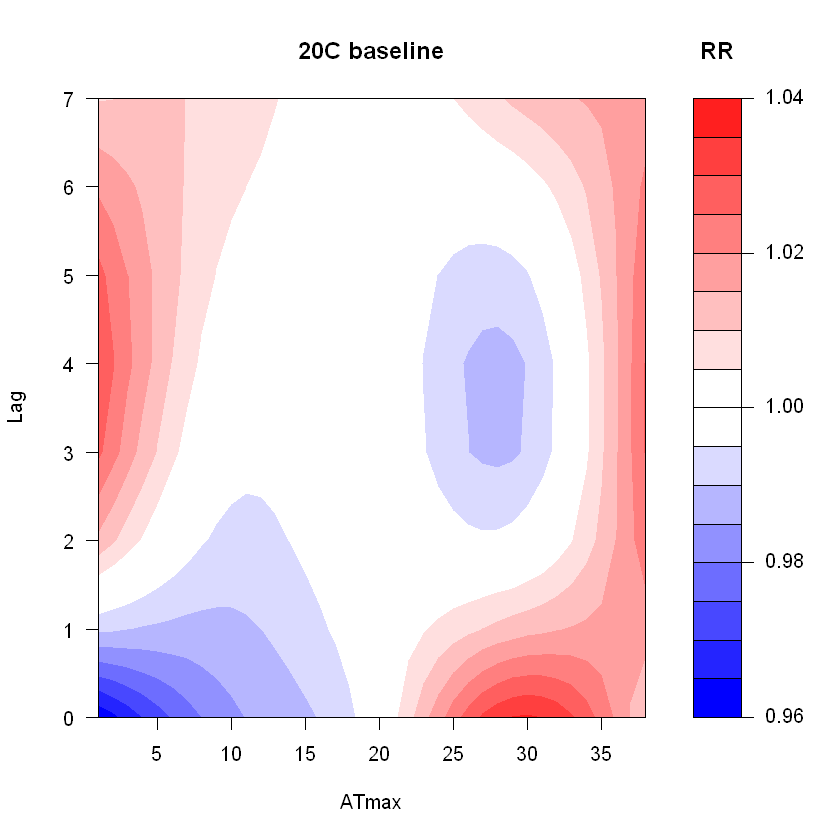

In [6]:
plot(pred1,"contour",xlab="ATmax",key.title=title("RR"),plot.title=title("20C baseline",xlab="ATmax",ylab="Lag"))

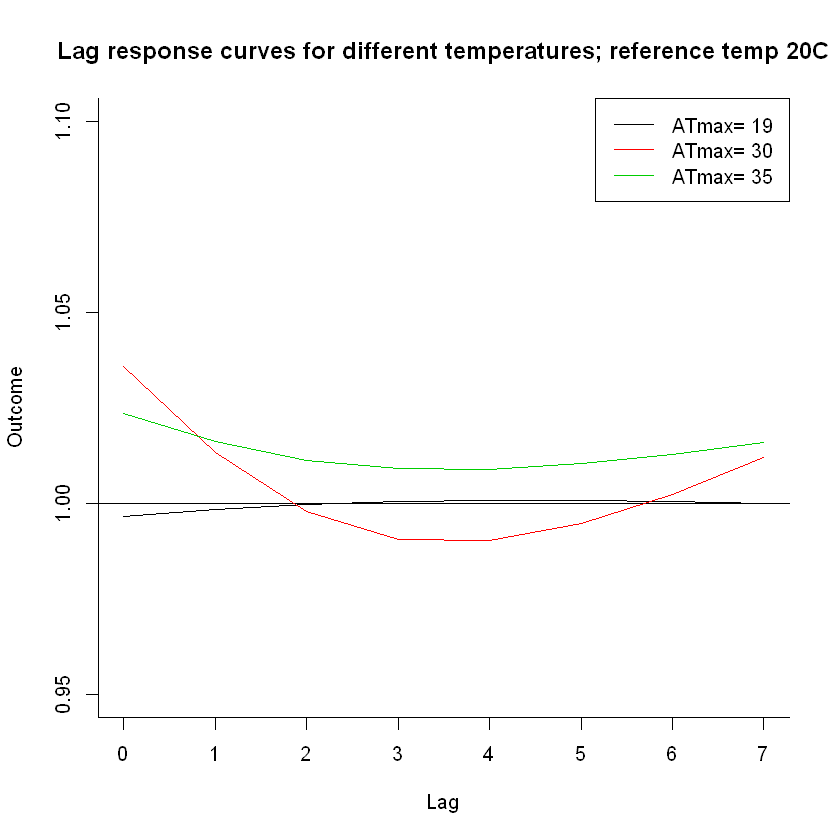

In [7]:
plot(pred1,"slices",var=20,ci="n",col=1,ylim=c(0.95,1.1),lwd=1.5,main="Lag response curves for different temperatures; reference temp 20C")
for(i in 1:3) lines(pred1,"slices",var=c(19,30,35)[i],col=i,lwd=1.5)
legend("topright",paste("ATmax=",c(19,30,35)),col=1:3,lwd=1.5)

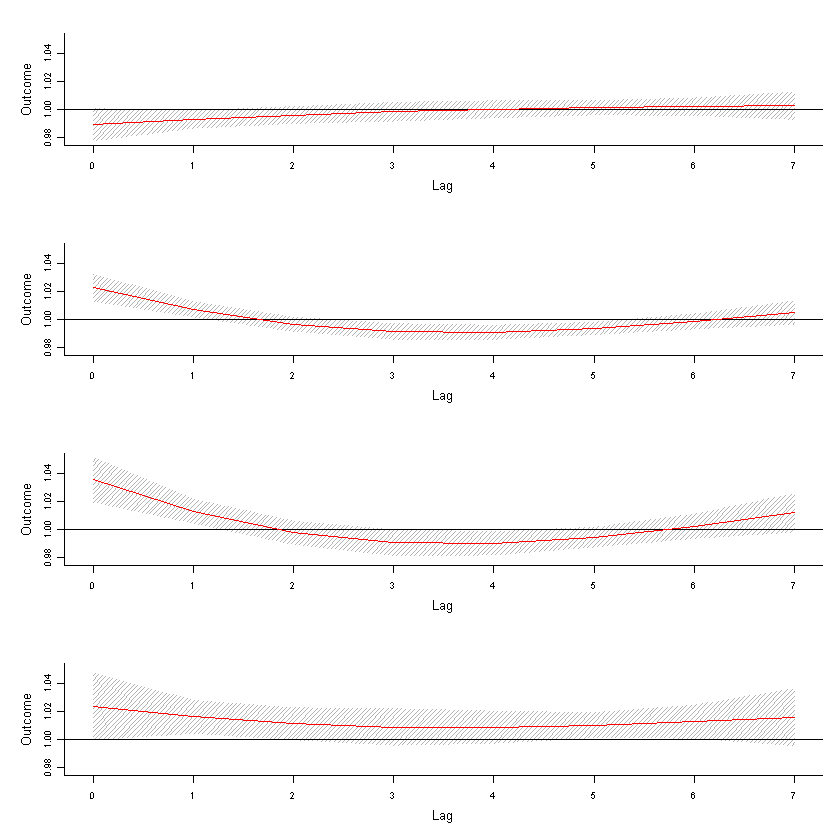

In [8]:
plot(pred1,"slices",var=c(15,25,30,35),col=2,ci.arg=list(density=40,col=grey(0.7)))

extract cumulative effect of 32C (relative to 20C) over 5 days of lag, plus 95% CI:

In [9]:
pred1$allRRfit["32"]	##cumulative
cbind(pred1$allRRlow,pred1$allRRhigh)["32",]	##95% CI
cbind(sum(zip_census$POP),mean(dane_df$ADMITS))

32 
1.062456

[1] 1.022583 1.103884

482805,256.6052


# reducing a DLNM

Reducing a bi-dimensional DLNM produces summaries defined in the the dimension of predictor or lags only, and 
re-expresses it in terms of modified parameters of the one-dimensional basis functions chosen for that space.
Useful for plotting associations. This example uses the countywide admissions, but it can be combined with any 
of the code blocks above.

In [16]:
varknots=with(dane_df, equalknots(ATMAX,fun="ns",df=4))
lagknots=logknots(5,1)
cb1=with(dane_df, crossbasis(ATMAX,lag=7,argvar=list(fun="ns",knots=varknots,cen=20),arglag=list(knots=lagknots)))
mdl1=with(dane_df, glmer(ADMITS~cb1+ns(obsno,3)+DOW+(1|YEAR/WEEK/DOW),family=poisson())); AIC(mdl1)
pred1=crosspred(cb1,mdl1,by=1)

redall=crossreduce(cb1,mdl1)                      #overall cumulative
redlag=crossreduce(cb1,mdl1,type="lag",value=3)   #lag specific exposure/response relationship (lag of 3 days currently specified)
redvar=crossreduce(cb1,mdl1,type="var",value=32)  #temperature specific lag/response relationship (temp of 33C currently specified)

Warning message in checkonebasis(fun, args, cen):
"centering through 'cen' now applied at the prediction stage. See ?crosspred"Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 0.0316882 (tol = 0.001, component 1)"

[1] 6606.835

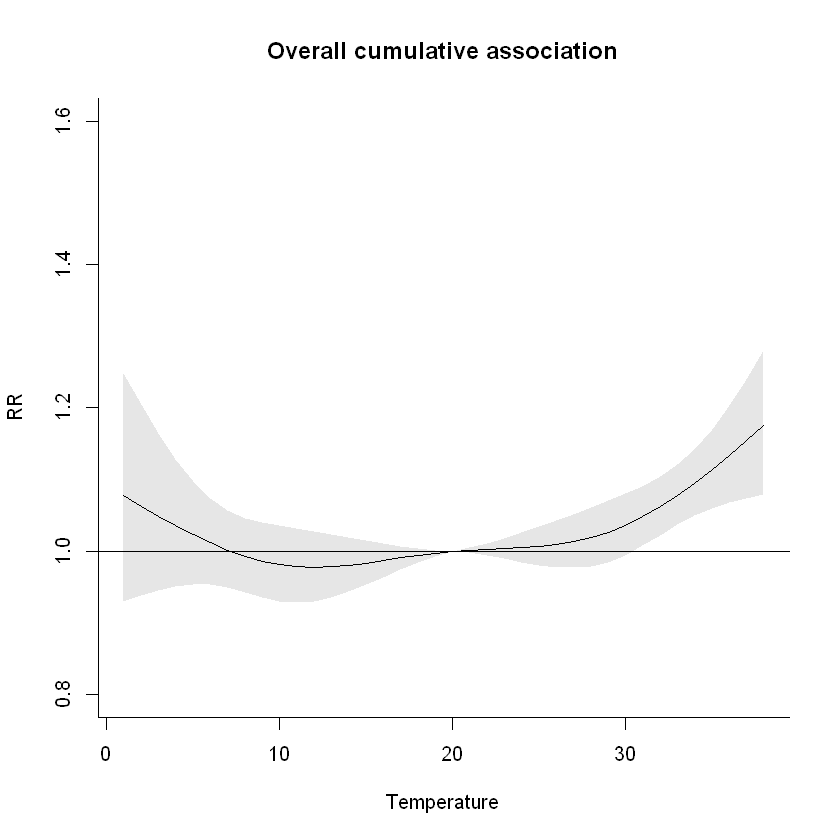

In [17]:
#cumulative increase in admits over a lag of 3 days
plot(pred1,"overall",xlab="Temperature",ylab="RR",ylim=c(0.8,1.6),main="Overall cumulative association")

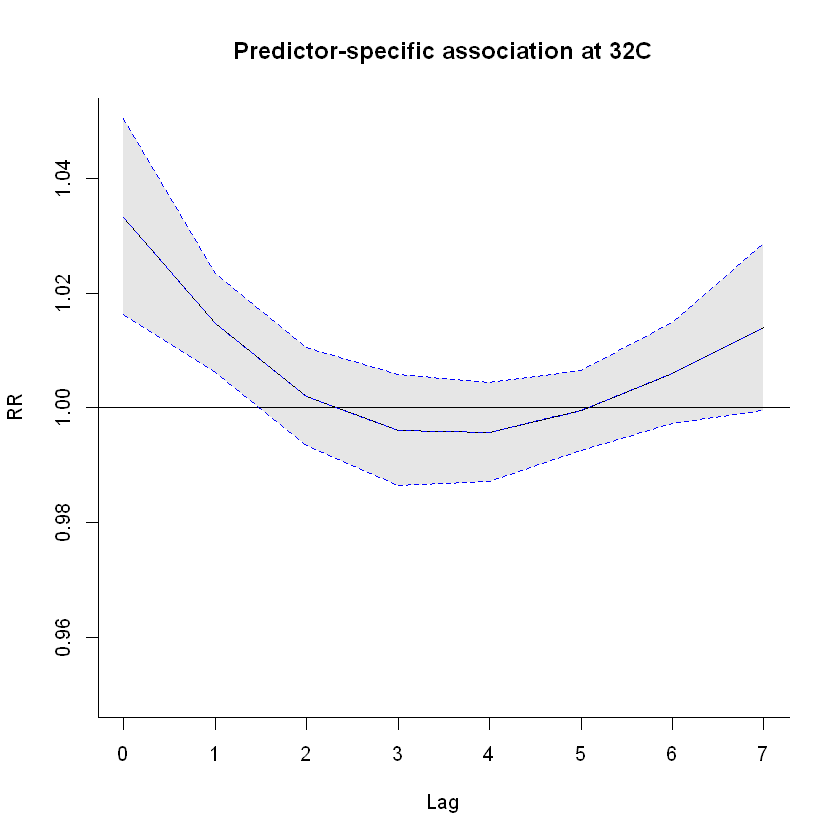

In [18]:
#change in RR at various lags at 33C
plot(pred1,"slices",var=32,ylab="RR",ylim=c(0.95,1.05),main="Predictor-specific association at 32C")
lines(redvar,ci="lines",col=4,lty=2)

# all zip, time admissions

fit DLNM with all data (all zips, all days), with day-of-year nested in year and year nested in zip

In [ ]:
varknots = with(zip_df, equalknots(ATMAX,fun="ns",df=5))
lagknots = logknots(5,1)
zip_df = scale(zip_df)
cb1 = with(zip_df, crossbasis(ATMAX,lag=7,argvar=list(fun="ns",knots=varknots,cen=20),arglag=list(knots=lagknots)))
md11 = with(zip_df, glmer(ADMITS ~ offset(log(POP)) + scale(MEDIAN_INC) + scale(PNONWHITE) + scale(PDISABLED) + DOW + cb1 + ns(obsno,3) + (1|ZIP/YEAR/DOY), family=poisson))
#mdl2 = with(zip_df, glmer(ADMITS ~ offset(log(POP)) + scale(MEDIAN_INC) + scale(PNONWHITE) + scale(PDISABLED) + DOW + cb1 + (1|ZIP/YEAR/DOY), family=poisson))

pred1=crosspred(cb1,mdl1,by=1)

In [ ]:
plot(pred1,"contour",xlab="ATmax",key.title=title("RR"),plot.title=title("20C baseline",xlab="ATmax",ylab="Lag"))

In [ ]:
plot(pred1,"slices",var=20,ci="n",col=1,ylim=c(0.95,1.1),lwd=1.5,main="Lag response curves for different temperatures; reference temp 20C")
for(i in 1:3) lines(pred1,"slices",var=c(19,30,35)[i],col=i,lwd=1.5)
legend("topright",paste("Temperature=",c(19,30,35)),col=1:3,lwd=1.5)

In [ ]:
plot(pred1,"slices",var=c(15,25,30,35),col=2,ci.arg=list(density=40,col=grey(0.7)))

extract cumulative effect of 32C (relative to 20C) over 5 days of lag, plus 95% CI:

In [ ]:
pred1$allRRfit["32"]	##cumulative
cbind(pred1$allRRlow,pred1$allRRhigh)["32",]	##95% CI
cbind(sum(zip_census$POP),mean(dane_df$ADMITS))

# individual zip admissions

fits a DLNM for each zip individually

In [ ]:
zips = levels(factor(zip_census$ZIP))

for (i in 1:length(zips)){
   tryCatch({
	z1 = zips[i]
	df1 = subset(zip_df,ZIP==z1)
	varknots=with(df1, equalknots(ATMAX,fun="ns",df=4))
	lagknots=logknots(5,1)
	cb1=with(df1, crossbasis(ATMAX,lag=7,argvar=list(fun="ns",knots=varknots,cen=20),arglag=list(knots=lagknots)))
	mdl1=with(df1, glmer(ADMITS~cb1+ns(obsno,3)+DOW+(1|YEAR/WEEK/DOW),family=poisson())); AIC(mdl1)

	pred1=crosspred(cb1,mdl1,by=1)

	outname = paste(z1,"curves.tiff",sep="_")
	tiff(outname,height=2400,width=700,res=300)
	par(mar=c(0.1,0.1,0.1,0.1), mai = c(0.1, 0.1, 0.1, 0.1))
	plot(pred1,"slices",var=c(15,25,30,35),col=2,ci.arg=list(density=40,col=grey(0.7)),xlab='n')
	dev.off()
   }, error=function(e){cat("ERROR :",conditionMessage(e), "\n")})
}